# **Import Needed Modules**

In [1]:
!pip install tensorflow==2.9.1

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [3]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Sooty Mould
1,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Sooty Mould
2,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Sooty Mould
3,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Sooty Mould
4,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Sooty Mould
...,...,...
4016,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Anthracnose
4017,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Anthracnose
4018,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Anthracnose
4019,/content/drive/MyDrive/MLDP_Dataset/Mango_Leaf...,Anthracnose


### **Split dataframe into train, valid, and test**

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.8, shuffle= True, random_state= 123)

### **Create image data generator**

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3216 validated image filenames belonging to 8 classes.
Found 644 validated image filenames belonging to 8 classes.
Found 161 validated image filenames belonging to 8 classes.


### **Show sample from train data**

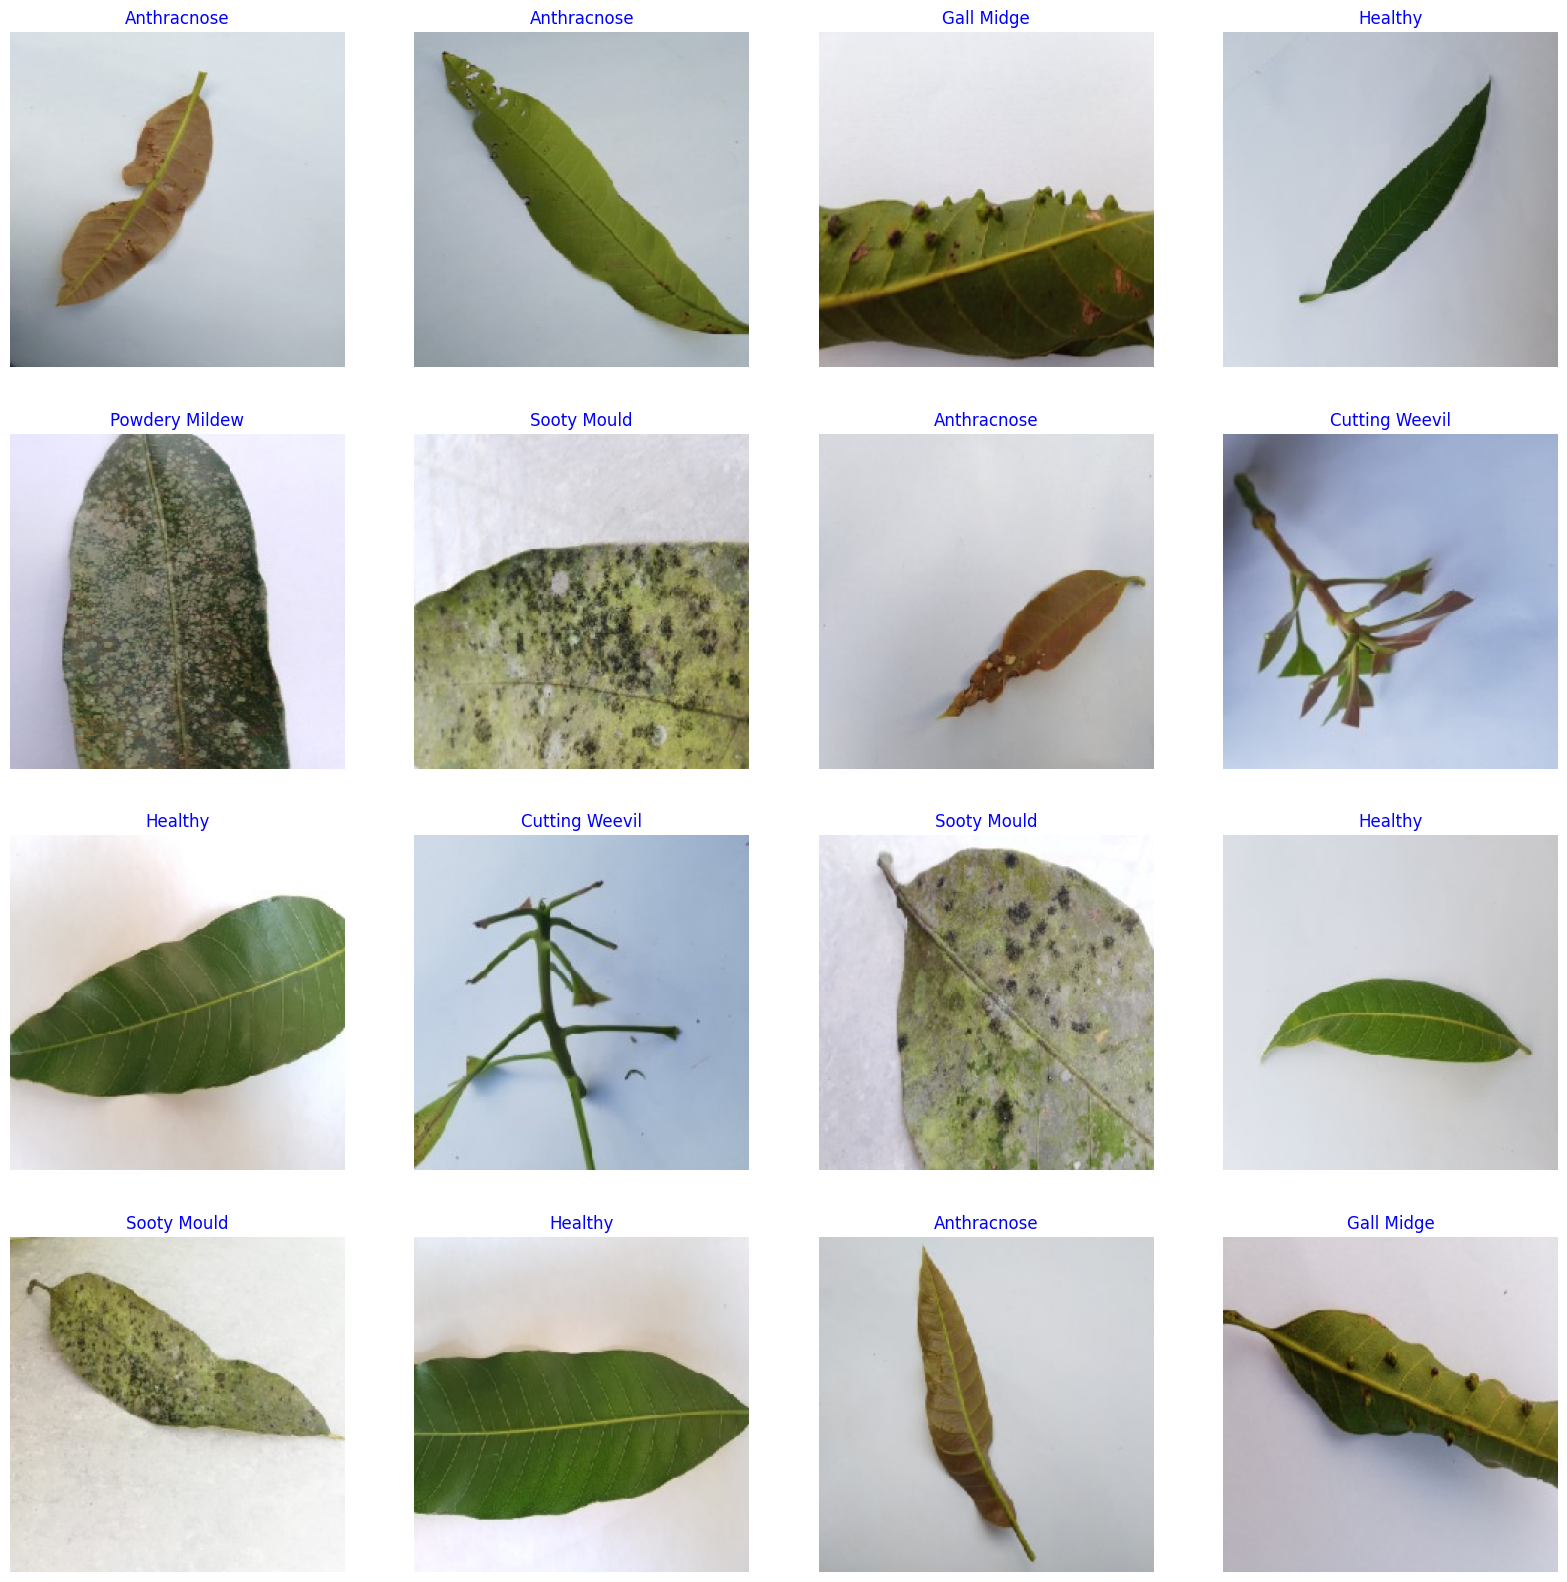

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 4,384,683
Trainable params: 4,340,100
Non-trainable params: 44,583
_________________________________________

#### **Train model**

In [9]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
201/201 [==============================] - 1079s 5s/step - loss: 6.7420 - accuracy: 0.9098 - val_loss: 5.4154 - val_accuracy: 0.9969
Epoch 2/10
201/201 [==============================] - 920s 5s/step - loss: 4.4510 - accuracy: 0.9848 - val_loss: 3.6052 - val_accuracy: 0.9984
Epoch 3/10
201/201 [==============================] - 921s 5s/step - loss: 2.9665 - accuracy: 0.9950 - val_loss: 2.3633 - val_accuracy: 1.0000
Epoch 4/10
201/201 [==============================] - 909s 5s/step - loss: 1.9597 - accuracy: 0.9950 - val_loss: 1.5494 - val_accuracy: 0.9969
Epoch 5/10
201/201 [==============================] - 906s 5s/step - loss: 1.3007 - accuracy: 0.9960 - val_loss: 1.0031 - val_accuracy: 1.0000
Epoch 6/10
201/201 [==============================] - 897s 4s/step - loss: 0.8680 - accuracy: 0.9963 - val_loss: 0.6638 - val_accuracy: 1.0000
Epoch 7/10
201/201 [==============================] - 903s 4s/step - loss: 0.5958 - accuracy: 0.9978 - val_loss: 0.4569 - val_accuracy: 1.000

#### **Display model performance**

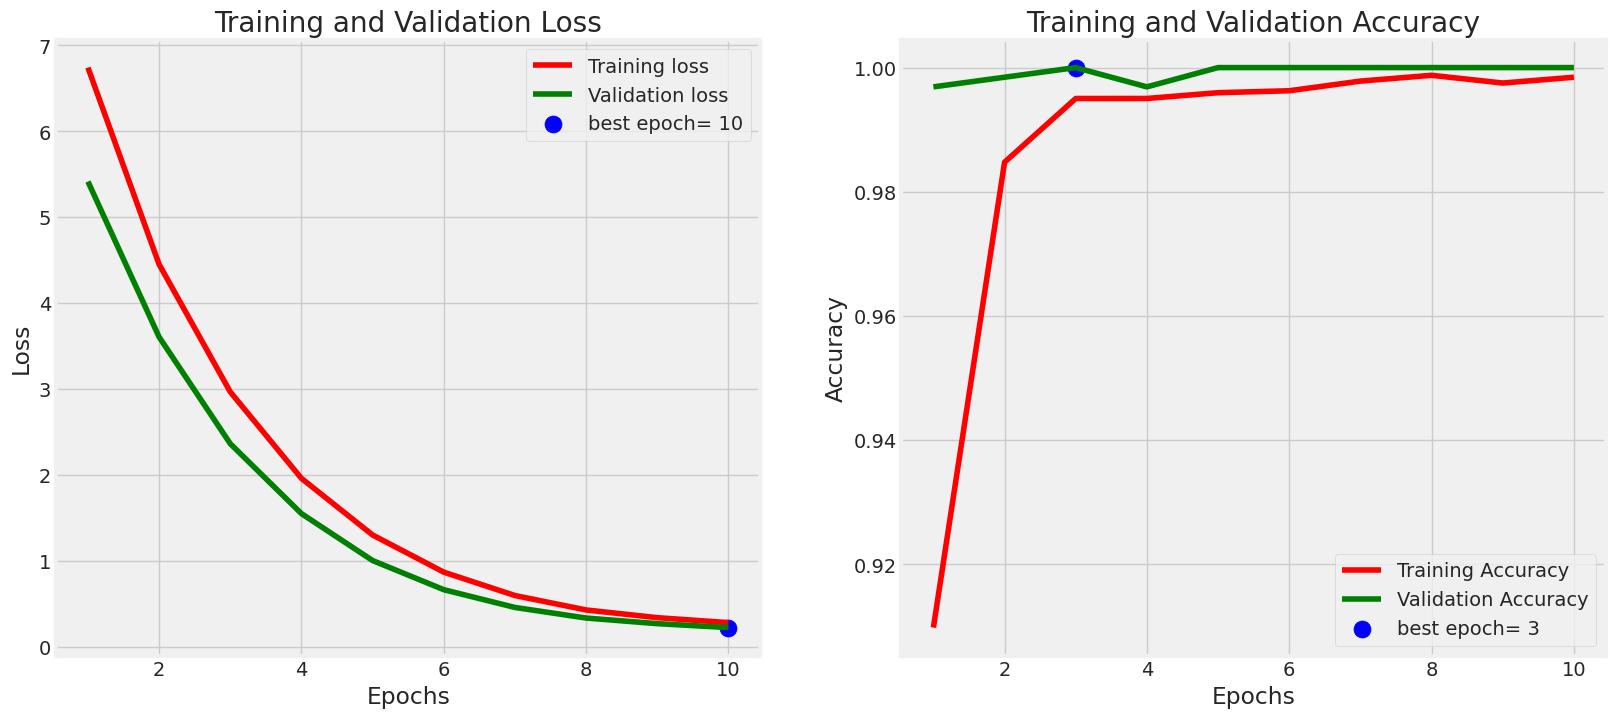

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 35s 6s/step - loss: 0.2221 - accuracy: 1.0000
Train Loss:  0.22374418377876282
Train Accuracy:  1.0
--------------------
Validation Loss:  0.22198404371738434
Validation Accuracy:  1.0
--------------------
Test Loss:  0.22212360799312592
Test Accuracy:  1.0


# **Get Predictions**

In [18]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

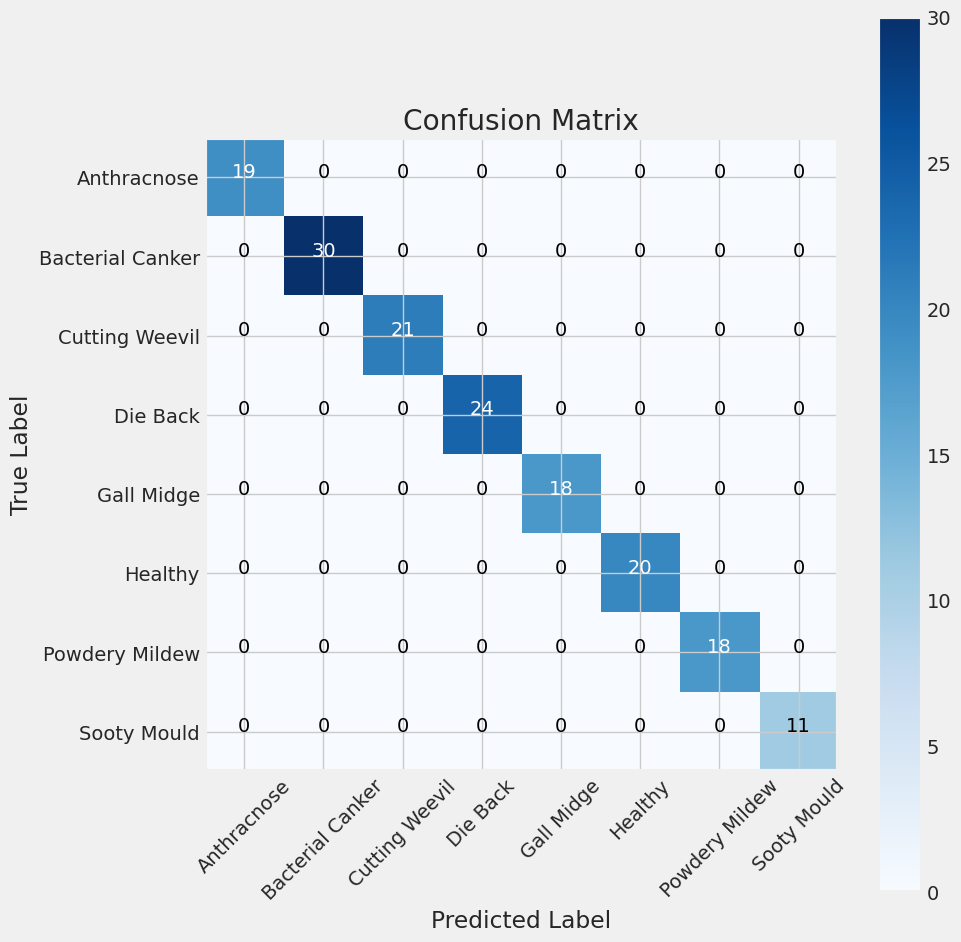

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

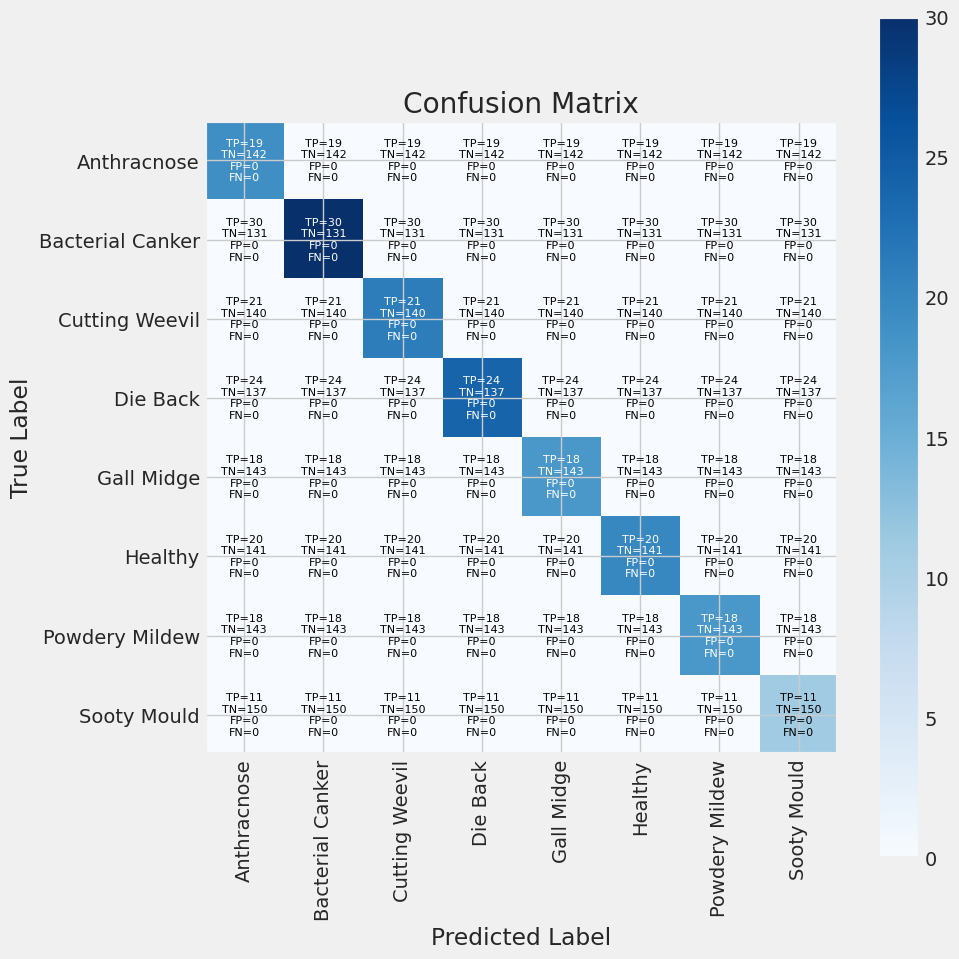

In [21]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Calculate TP, TN, FP, FN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Add text annotations with smaller font size
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"TP={TP[i]:0.0f}\nTN={TN[i]:0.0f}\nFP={FP[j]:0.0f}\nFN={FN[j]:0.0f}", horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=8)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        19
Bacterial Canker       1.00      1.00      1.00        30
  Cutting Weevil       1.00      1.00      1.00        21
        Die Back       1.00      1.00      1.00        24
      Gall Midge       1.00      1.00      1.00        18
         Healthy       1.00      1.00      1.00        20
  Powdery Mildew       1.00      1.00      1.00        18
     Sooty Mould       1.00      1.00      1.00        11

        accuracy                           1.00       161
       macro avg       1.00      1.00      1.00       161
    weighted avg       1.00      1.00      1.00       161



#### **Save model**

In [25]:
model_name = model.input_names[0][:-6]
subject = 'Mango Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Mango Diseases-100.00.h5
weights were saved as efficientnetb0-Mango Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [26]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Mango Diseases-class_dict.csv
